In [1]:
import os
import sys
import pandas as pd
import xgboost as xgb

sys.path.insert(0,'/home/sara/Downloads/hockey/src/training/')
from visuals import generate_shot_classifier_charts
from utils import clf_performance_metrics

EXP_NAME = 'xgboost_baseline'
RANDOM_STATE = 1729
TRAIN_COLS_BASELINE = ['distance_from_net', 'angle']
LABEL_COL = 'is_goal'

In [2]:
def load_train_and_validation():
    train = pd.read_csv("/home/sara/Downloads/hockey/data/processed/train_processed.csv")
    val = pd.read_csv("/home/sara/Downloads/hockey/data/processed/validation_processed.csv")

    X_train, Y_train = train[TRAIN_COLS_BASELINE], train[LABEL_COL].astype(int)
    X_val, Y_val = val[TRAIN_COLS_BASELINE], val[LABEL_COL].astype(int)

    return X_train, Y_train, X_val, Y_val

In [3]:
X_train, Y_train, X_val, Y_val = load_train_and_validation()

params = {
    "max_depth": 2,
    "eta": 1,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "num_boost_round": 100,
}

clf = xgb.XGBClassifier(**params)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]
res = pd.DataFrame({"y_true": Y_val, "y_preds": y_pred, "y_proba": y_proba})

# saving predictions
preds_path = f"/home/sara/Downloads/DS_xgboost/"
if not os.path.exists(preds_path):
    os.makedirs(preds_path)
res.to_csv(os.path.join(preds_path, f"{EXP_NAME}.csv"), index=False)

perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=True)

/home/sara/anaconda3/envs/ift6758-conda-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:46:44] WARNING: ../src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




INFO:root:Accuracy is  0.905
INFO:root:Confusion Matrix:
 [[46125     7]
 [ 4814    15]]
INFO:root:F1 score is  0.006
INFO:root:Precision score is  0.682
INFO:root:Recall score is  0.003


In [2]:
RANDOM_STATE = 1729
TRAIN_COLS = ['distance_from_net', 'angle']
LABEL_COL = 'is_goal'

INFREQUENT_STOPPAGE_EVENTS = [
    'PERIOD_START', 'PERIOD_READY', 'PERIOD_END', 'SHOOTOUT_COMPLETE', 'PERIOD_OFFICIAL', 
    'GAME_OFFICIAL', 'PENALTY', 'GOAL', 'CHALLENGE'
]

KNOWN_NON_TRAIN_COLS = [
    'game_id', 'event_index', 'description',
    'game_sec', 'time', 'time_remaining', 'date', 'prev_event_time_diff',
    'is_goal'
]

# TODO: throw out is_empty_net + associated rows?
# see https://piazza.com/class/krgt4sfrgfp278?cid=255
TRAIN_COLS_PART_4 = [
    'game_sec', 'period',
    'secondary_type',
    'coordinate_x', 'coordinate_y', 'distance_from_net', 'angle',
    'prev_event_type', 'angle_between_prev_event', 'distance_from_prev_event', 'prev_event_time_diff',
    'speed', 'is_rebound', 'rebound_angle', 'is_empty_net',
    'prev_event_x_coord', 'prev_event_y_coord',
]  # 'period_type', 'shooter_team_name', 'shooter_id', 'goalie_name',

In [3]:
def load_train_and_validation():
    train = pd.read_csv("../data/processed/train_processed.csv")
    val = pd.read_csv("../data/processed/validation_processed.csv")

    X_train, Y_train =  train[TRAIN_COLS_PART_4], train[LABEL_COL].astype(int)
    X_val, Y_val = val[TRAIN_COLS_PART_4], val[LABEL_COL].astype(int)

    return X_train, Y_train, X_val, Y_val


def preprocess(X_train, X_val):
    # TODO: try working with categorical data directly on GPU
    # see "1.4.17 Categorical Data" in https://buildmedia.readthedocs.org/media/pdf/xgboost/latest/xgboost.pdf

    X_train['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_train['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_val['secondary_type'].replace({'Tip-in': 'Deflection'}, inplace=True)
    X_val['prev_event_type'].replace(
        to_replace=INFREQUENT_STOPPAGE_EVENTS, value = 'STOP', inplace=True
    )

    X_train = pd.get_dummies(X_train, ['shot', 'prev_event'])
    X_val = pd.get_dummies(X_val, ['shot', 'prev_event'])

    return X_train, X_val

In [4]:
# hyperparams search
def get_xgboost_hparams_tuning(X, y, feat_select_method_name,
                               save_result_path="/home/sara/Downloads/DS_xgboost/"):

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='logloss', use_label_encoder=False
    )

    hparam_search_ranges = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(1, 6),
        "colsample_bytree": uniform(.33, 1-.33),
        "subsample": uniform(0.5, 1-.5),
        "learning_rate": uniform(0.03, .67-.03),
        "gamma": uniform(0, 0.5)
    }

    search = RandomizedSearchCV(
        xgb_model, param_distributions=hparam_search_ranges,
        random_state=1729, n_iter=50, cv=5, verbose=2, n_jobs=1, return_train_score=True, refit=True
    )

    search.fit(X.values, y.values)

    search_results_summary = pd.DataFrame(search.cv_results_)
    search_results_summary.to_csv(os.path.join(save_result_path, feat_select_method_name + ".csv"))

    clf_optimal = search.best_estimator_
    opt_params={key:getattr(clf_optimal,key) for key in hparam_search_ranges}
    
    return clf_optimal


In [5]:
def scale_df(X_train, X_val):
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train.values)

    X_train_scaled = pd.DataFrame(
        data=scaler.transform(X_train.values),
        index=X_train.index,
        columns=X_train.columns
    )

    X_val_scaled = pd.DataFrame(
        data=scaler.transform(X_val.values),
        index=X_val.index,
        columns=X_val.columns
    )

    return X_train_scaled, X_val_scaled

In [6]:
X_train, Y_train, X_val, Y_val = load_train_and_validation()
X_train, X_val = preprocess(X_train, X_val)

## Feature selection: Lasso

In [7]:
import sklearn
from sklearn import feature_selection
from sklearn import linear_model

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

In [8]:
X_train = X_train.fillna(0)

In [13]:
selector = feature_selection.SelectFromModel(estimator=linear_model.Lasso(alpha=0.001)).fit(X_train, Y_train)
selected_feats = list(selector.get_feature_names_out())

In [14]:
selected_feats

['coordinate_x',
 'coordinate_y',
 'distance_from_net',
 'angle',
 'angle_between_prev_event',
 'distance_from_prev_event',
 'prev_event_time_diff',
 'speed',
 'is_rebound',
 'rebound_angle',
 'is_empty_net',
 'prev_event_x_coord',
 'shot_Backhand',
 'shot_Tip-In',
 'shot_Wrist Shot',
 'prev_event_FACEOFF',
 'prev_event_GIVEAWAY',
 'prev_event_HIT',
 'prev_event_SHOT']

In [10]:
len(selected_feats)

19

In [11]:
X_train_lasso, X_val_lasso = X_train[selected_feats], X_val[selected_feats]

### Tuning XGBoost model with the selected features from Lasso

In [17]:
# hparams tuning with selected lasso features
# clf_optimal = get_xgboost_hparams_tuning(X_train_lasso, Y_train,
#                                  feat_select_method_name = "hparams_lasso",
#                                  save_result_path="/home/sara/Downloads/DS_xgboost/")

In [18]:
# hparam_search_ranges = {
#         "n_estimators": randint(100, 500),
#         "max_depth": randint(1, 6),
#         "colsample_bytree": uniform(.33, 1-.33),
#         "subsample": uniform(0.5, 1-.5),
#         "learning_rate": uniform(0.03, .67-.03),
#         "gamma": uniform(0, 0.5)
#     }
# opt_params={key:getattr(clf_optimal, key) for key in hparam_search_ranges}

In [19]:
opt_params

{'n_estimators': 495,
 'max_depth': 5,
 'colsample_bytree': 0.5395748217887331,
 'subsample': 0.9262101866374273,
 'learning_rate': 0.06161853852618868,
 'gamma': 0.18476657843168925}

### Training the XGBoost model

In [20]:
# chosen via results of hparam optimization search
params = {
    'max_depth':5, 'n_estimators': 495, 'learning_rate': 0.062, 'gamma': 0.184,
    'objective':'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False
}

clf_lasso = xgb.XGBClassifier(**params)
clf_lasso.fit(X_train_lasso, Y_train)

y_pred = clf_lasso.predict(X_val_lasso)
y_proba = clf_lasso.predict_proba(X_val_lasso)[:,1]
res = pd.DataFrame({
    'y_true': Y_val,
    'y_preds': y_pred,
    'y_proba': y_proba
})

exp_name = "xgboost_feats_lasso_tuned"
res.to_csv(f"/home/sara/Downloads/DS_xgboost/{exp_name}.csv", index=False)

perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=True)
perf_metrics

INFO:root:Accuracy is  0.921
INFO:root:Confusion Matrix:
 [[45975   157]
 [ 3855   974]]
INFO:root:F1 score is  0.327
INFO:root:Precision score is  0.861
INFO:root:Recall score is  0.202


{'accuracy': 0.9212731304330762,
 'f1_score': 0.3268456375838926,
 'precision': 0.861184792219275,
 'recall': 0.20169807413543175}

## Feature selection: SHAP

In [27]:
import shap

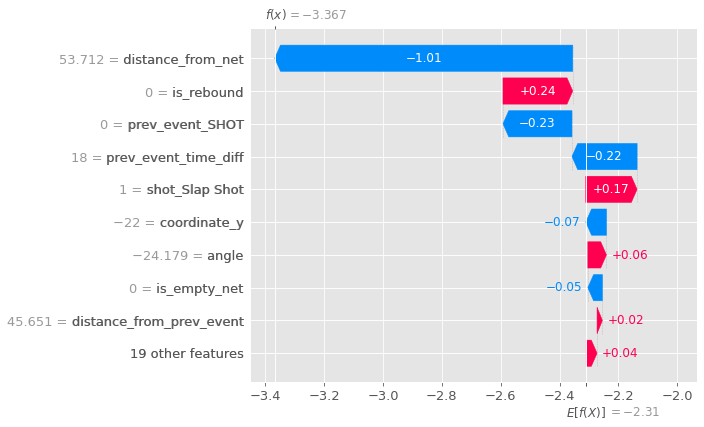

In [30]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(clf)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[88])

In [31]:
shap_feats = ['distance_from_net',
                'is_rebound',
                'prev_event_SHOT',
                'prev_event_time_diff',
                'angle',
                'is_empty_net',
                'shot_Snap Shot',
                'shot_Slap Shot',
                'distance_from_prev_event',
                'coordinate_y',
                'prev_event_HIT']

In [39]:
X_train_shap, X_val_shap = X_train[shap_feats], X_val[shap_feats]

### Tune hparams for SHAP selected features

In [48]:
# # hparams tuning with selected lasso features
# clf_optimal_shap = get_xgboost_hparams_tuning(X_train_shap, Y_train,
#                                  feat_select_method_name = "hparams_shap",
#                                  save_result_path="/home/sara/Downloads/DS_xgboost/")

In [43]:
hparam_search_ranges = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(1, 6),
        "colsample_bytree": uniform(.33, 1-.33),
        "subsample": uniform(0.5, 1-.5),
        "learning_rate": uniform(0.03, .67-.03),
        "gamma": uniform(0, 0.5)
    }
opt_params={key:getattr(clf_optimal_shap, key) for key in hparam_search_ranges}

In [44]:
opt_params

{'n_estimators': 495,
 'max_depth': 5,
 'colsample_bytree': 0.5395748217887331,
 'subsample': 0.9262101866374273,
 'learning_rate': 0.06161853852618868,
 'gamma': 0.18476657843168925}

In [45]:
# hparams tuned on SHAP selected features
params = {
    'max_depth':5 , 'n_estimators': 495, 'learning_rate': 0.062, 'gamma': 0.184,
    'objective':'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False
}

clf_lasso = xgb.XGBClassifier(**params)
clf_lasso.fit(X_train_shap, Y_train)

y_pred = clf_lasso.predict(X_val_shap)
y_proba = clf_lasso.predict_proba(X_val_shap)[:,1]
res = pd.DataFrame({
    'y_true': Y_val,
    'y_preds': y_pred,
    'y_proba': y_proba
})

exp_name = "xgboost_feats_shap_tuned"
res.to_csv(f"/home/sara/Downloads/DS_xgboost/{exp_name}.csv", index=False)

perf_metrics = clf_performance_metrics(Y_val, y_pred, y_proba, verbose=True)

INFO:root:Accuracy is  0.921
INFO:root:Confusion Matrix:
 [[45983   149]
 [ 3864   965]]
INFO:root:F1 score is  0.325
INFO:root:Precision score is  0.866
INFO:root:Recall score is  0.200


# Visualizing figures

In [10]:
def generate_adv_model_figures():
    experiment_prediction_filenames = {
        # "NN_adv": "../models/predictions/NN_adv.csv",
        # "xgboost_feats_non_corr": "../models/predictions/xgboost_feats_non_corr.csv",
        "xgboost_SMOTE": "../models/predictions/xgboost_SMOTE.csv",
        "lr_SMOTE": "../models/predictions/lr_SMOTE.csv",
    }

    exp_preds = {exp: pd.read_csv(fname) for exp, fname in experiment_prediction_filenames.items()}

    exp_names, y_trues, y_preds, y_probas = [], [], [], []
    for exp, preds in exp_preds.items():
        exp_names.append(exp)
        y_trues.append(preds['y_true'].values)
        y_preds.append(preds['y_preds'].values)
        y_probas.append(preds['y_proba'].values)

    title = "Visual Summary - SMOTE"
    image_dir = "../figures/advanced_models/"

    generate_shot_classifier_charts(
        y_trues, y_preds, y_probas, exp_names,
        title=title, image_dir=image_dir
    )

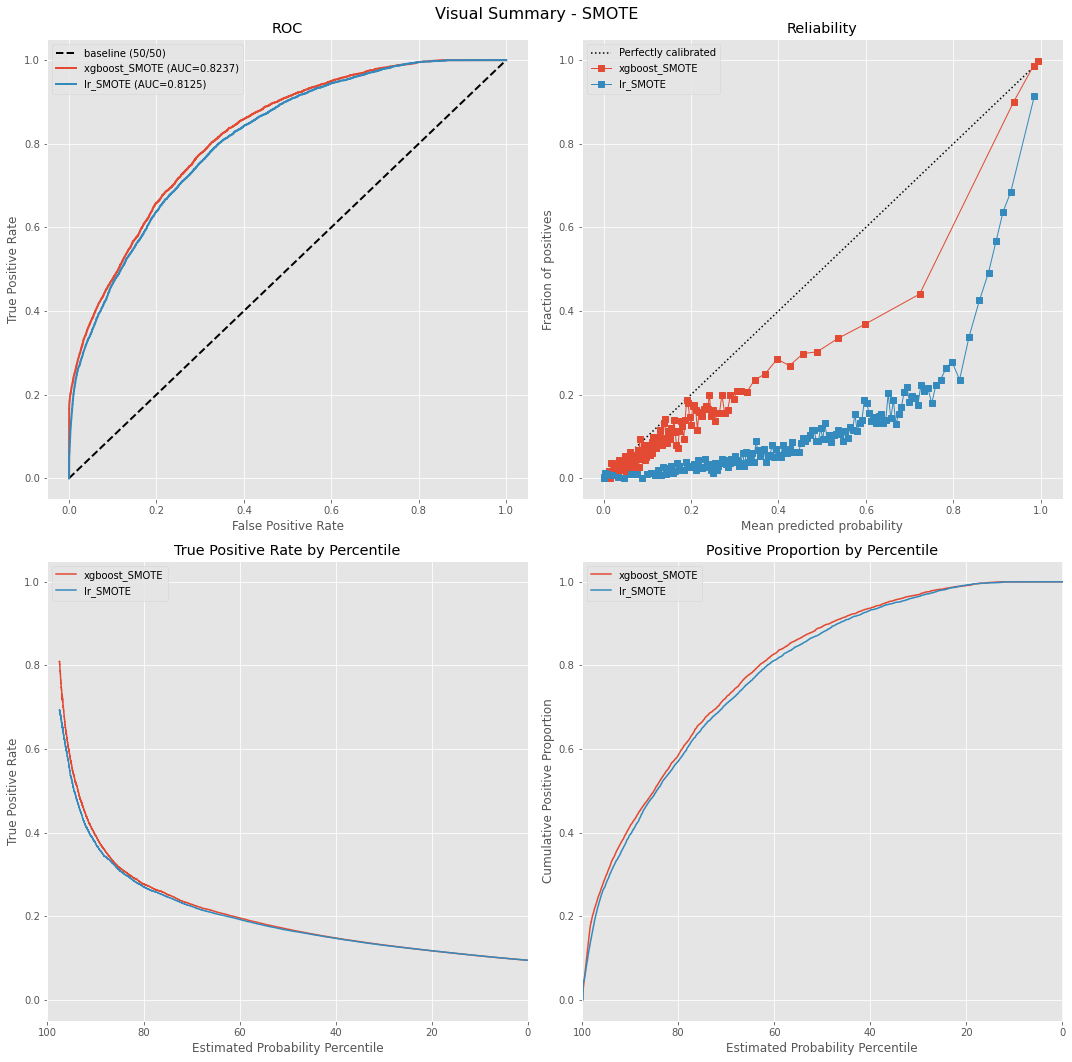

In [11]:
generate_adv_model_figures()